# Direct Grib Read 

If you have installed more recent versions of pygrib, you can ingest grib mosaics directly without conversion to netCDF. This speeds up the ingest by ~15-20 seconds. This notebook will also demonstrate how to use MMM-Py with cartopy, and how to download near-realtime data from NCEP.

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import glob
import mmmpy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.img_tiles import StamenTerrain
import pygrib
import os
import pyart
%matplotlib inline

### Download MRMS directly from NCEP

In [2]:
def download_files(input_dt, max_seconds=300):
    """
    This function takes an input datetime object, and will try to match with the closest mosaics in time
    that are available at NCEP. Note that NCEP does not archive much beyond 24 hours of data.
    
    Parameters
    ----------
    input_dt : datetime.datetime object
        input datetime object, will try to find closest file in time on NCEP server
    
    Other Parameters
    ----------------
    max_seconds : int or float
        Maximum number of seconds difference tolerated between input and selected datetimes,
        before file matching will fail
    
    Returns
    -------
    files : 1-D ndarray of strings
        Array of mosaic file names, ready for ingest into MMM-Py
    """
    baseurl = 'http://mrms.ncep.noaa.gov/data/3DReflPlus/'
    page1 = pd.read_html(baseurl)
    directories = np.array(page1[0][0][2:])
    urllist = []
    files = []
    for i, d in enumerate(directories):
        page2 = pd.read_html(baseurl + d)
        filelist = np.array(page2[0][0][2:])
        dts = []
        for filen in filelist:
            # Will need to change in event of a name change
            dts.append(dt.datetime.strptime(filen[32:47], '%Y%m%d-%H%M%S'))
        dts = np.array(dts)
        diff = np.abs((dts - input_dt))
        if np.min(diff).total_seconds() <= max_seconds:
            urllist.append(baseurl + d + filelist[np.argmin(diff)])
            files.append(filelist[np.argmin(diff)])
    for url in urllist:
        print(url)
        os.system('wget ' + url)
    return np.array(files)

In [3]:
files = download_files(dt.datetime.utcnow())

http://mrms.ncep.noaa.gov/data/3DReflPlus/MergedReflectivityQC_00.50/MRMS_MergedReflectivityQC_00.50_20170523-173437.grib2.gz
http://mrms.ncep.noaa.gov/data/3DReflPlus/MergedReflectivityQC_00.75/MRMS_MergedReflectivityQC_00.75_20170523-173437.grib2.gz
http://mrms.ncep.noaa.gov/data/3DReflPlus/MergedReflectivityQC_01.00/MRMS_MergedReflectivityQC_01.00_20170523-173437.grib2.gz
http://mrms.ncep.noaa.gov/data/3DReflPlus/MergedReflectivityQC_01.25/MRMS_MergedReflectivityQC_01.25_20170523-173437.grib2.gz
http://mrms.ncep.noaa.gov/data/3DReflPlus/MergedReflectivityQC_01.50/MRMS_MergedReflectivityQC_01.50_20170523-173437.grib2.gz
http://mrms.ncep.noaa.gov/data/3DReflPlus/MergedReflectivityQC_01.75/MRMS_MergedReflectivityQC_01.75_20170523-173437.grib2.gz
http://mrms.ncep.noaa.gov/data/3DReflPlus/MergedReflectivityQC_02.00/MRMS_MergedReflectivityQC_02.00_20170523-173437.grib2.gz
http://mrms.ncep.noaa.gov/data/3DReflPlus/MergedReflectivityQC_02.25/MRMS_MergedReflectivityQC_02.25_20170523-173437.g

In [4]:
files

array(['MRMS_MergedReflectivityQC_00.50_20170523-173437.grib2.gz',
       'MRMS_MergedReflectivityQC_00.75_20170523-173437.grib2.gz',
       'MRMS_MergedReflectivityQC_01.00_20170523-173437.grib2.gz',
       'MRMS_MergedReflectivityQC_01.25_20170523-173437.grib2.gz',
       'MRMS_MergedReflectivityQC_01.50_20170523-173437.grib2.gz',
       'MRMS_MergedReflectivityQC_01.75_20170523-173437.grib2.gz',
       'MRMS_MergedReflectivityQC_02.00_20170523-173437.grib2.gz',
       'MRMS_MergedReflectivityQC_02.25_20170523-173437.grib2.gz',
       'MRMS_MergedReflectivityQC_02.50_20170523-173437.grib2.gz',
       'MRMS_MergedReflectivityQC_02.75_20170523-173437.grib2.gz',
       'MRMS_MergedReflectivityQC_03.00_20170523-173437.grib2.gz',
       'MRMS_MergedReflectivityQC_03.50_20170523-173437.grib2.gz',
       'MRMS_MergedReflectivityQC_04.00_20170523-173437.grib2.gz',
       'MRMS_MergedReflectivityQC_04.50_20170523-173437.grib2.gz',
       'MRMS_MergedReflectivityQC_05.00_20170523-173437.grib2.

### Direct ingest of grib into MMM-Py

In [5]:
mosaic = mmmpy.MosaicTile(files)


********************
diag():
Printing basic metadata and making a simple plot
Data are from MRMS_MergedReflectivityQC_00.50_20170523-173437.grib2.gz
Min, Max Latitude = 20.005 54.995
Min, Max Longitude = -129.995 -60.0050000001
Heights (km) = [  0.5    0.75   1.     1.25   1.5    1.75   2.     2.25   2.5    2.75   3.
   3.5    4.     4.5    5.     5.5    6.     6.5    7.     7.5    8.     8.5
   9.    10.    11.    12.    13.    14.    15.    16.    17.    18.    19.  ]
Grid shape = (33, 3500, 7000)
Now plotting ...
Done!
********************



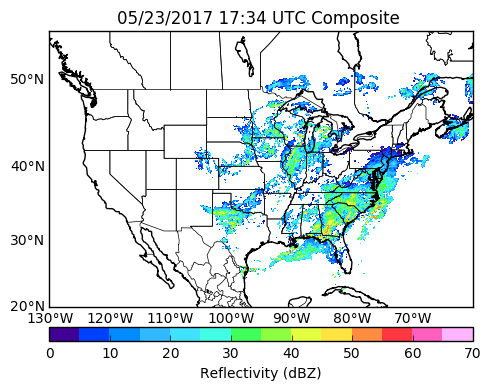

In [6]:
mosaic.diag()

### Plot with cartopy

/Users/tjlang/anaconda/lib/python2.7/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


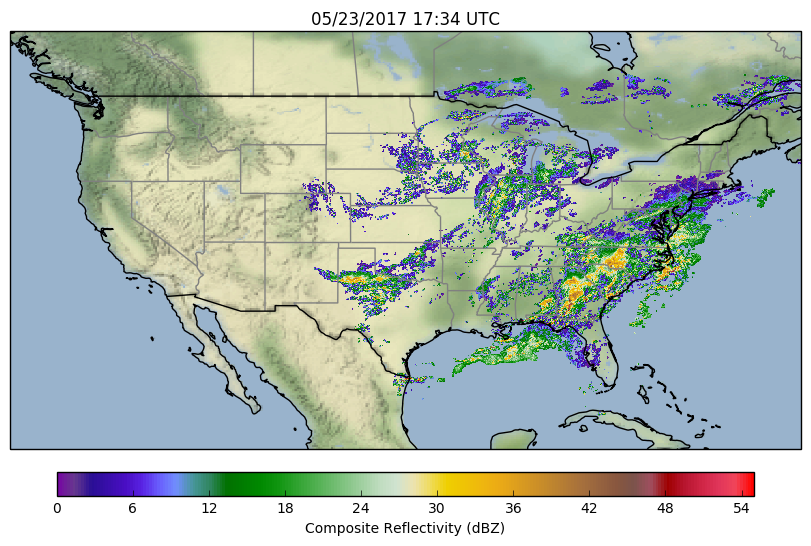

In [7]:
tiler = StamenTerrain()

ext = [-130, -65, 20, 50]
fig = plt.figure(figsize=(12, 6))
projection = ccrs.PlateCarree()  # ShadedReliefESRI().crs
ax = plt.axes(projection=projection)
ax.set_extent(ext)
ax.add_image(tiler, 3)

# Create a feature for States/Admin 1 regions at 1:10m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')
ax.add_feature(states_provinces, edgecolor='gray')

# Create a feature for Countries 0 regions at 1:10m from Natural Earth
countries = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_boundary_lines_land',
    scale='50m',
    facecolor='none')
ax.add_feature(countries, edgecolor='k')

ax.coastlines(resolution='50m')

mosaic.get_comp()
valmask = np.ma.masked_where(mosaic.mrefl3d_comp <= 0, mosaic.mrefl3d_comp)
cs = plt.pcolormesh(mosaic.Longitude, mosaic.Latitude, valmask, vmin=0, vmax=55,
                    cmap='pyart_Carbone42', transform=projection)
plt.colorbar(cs, label='Composite Reflectivity (dBZ)',
             orientation='horizontal', pad=0.05, shrink=0.75, fraction=0.05, aspect=30)
plt.title(dt.datetime.utcfromtimestamp(mosaic.Time).strftime('%m/%d/%Y %H:%M UTC'))